## Inceptionnet muti sz

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import os,shutil

# Fastai reloads
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Impost fastai
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
from fastai.callbacks import *
from fastai.imports import *
from fastai.callbacks.mem import PeakMemMetric

from pathlib import Path

from torchvision.models import *
from torch.nn import CrossEntropyLoss
import cv2
#import pretrainedmodels

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns

In [3]:
PATH=Path('data/')

## Create Data block (Try with 1/4 size)

In [4]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [5]:
img=open_image(PATH/'train_resized'/os.listdir(PATH/'train_resized')[1])

In [6]:
img.shape

torch.Size([3, 150, 210])

In [7]:
src_size=np.array(img.shape[1:]);src_size

array([150, 210])

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [9]:
data = (src.transform(tfms, size=src_size//4)
        .databunch(bs=256).normalize(imagenet_stats))        

In [10]:
data.classes

['1', '2', '3', '4', '5']

In [11]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: EmptyLabelList
,,,,
Path: data

## Try with ResNET 18

In [91]:
#f1 = partial(fbeta, thresh=0.2, beta = 1)

In [12]:
metrics_custom=[fbeta,accuracy_thresh]

In [13]:
learn=cnn_learner(data,models.vgg19_bn,metrics=metrics_custom)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/sayak_cowi/.torch/models/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:24<00:00, 23852900.16it/s]


In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


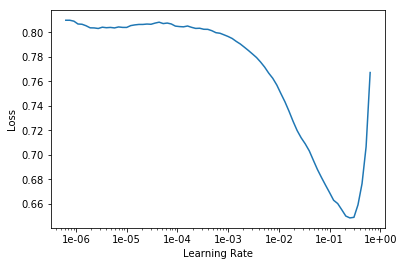

In [15]:
learn.recorder.plot()

In [16]:
lr=2e-2

In [17]:
learn.fit_one_cycle(15,slice(lr)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.719224,0.575695,0.557960,0.770880,00:04
1,0.596132,0.441804,0.455943,0.810880,00:04
2,0.520955,0.374767,0.654891,0.830560,00:04
3,0.466927,0.337577,0.709695,0.854720,00:04
4,0.427421,0.325307,0.729619,0.853600,00:04
5,0.393858,0.293158,0.761448,0.869920,00:04
6,0.365708,0.281515,0.774005,0.879840,00:04
7,0.343492,0.269552,0.779333,0.882400,00:04
8,0.324212,0.252426,0.797738,0.890560,00:04
9,0.307358,0.248734,0.805771,0.891520,00:04


AttributeError: 'NoneType' object has no attribute 'mixup'

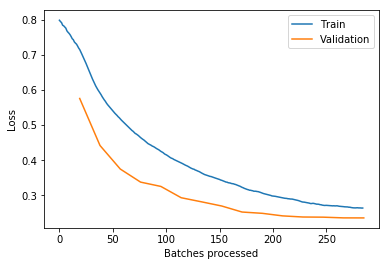

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('vgg19-5-imagenet-onefrth-stage-1')

In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


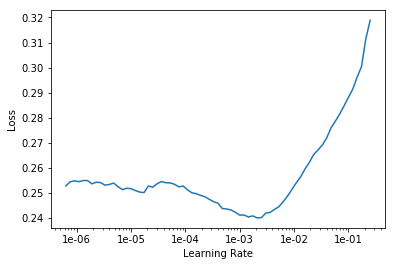

In [22]:
learn.recorder.plot()

In [24]:
lr=2e-4

In [25]:
learn.fit_one_cycle(15,slice(lr,3e-2)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.247817,0.251956,0.811067,0.908800,00:04
1,0.230260,0.287995,0.806152,0.905440,00:04
2,0.223079,0.615459,0.745105,0.894240,00:04
3,0.221174,0.731146,0.708800,0.876480,00:04
4,0.217025,0.315904,0.799581,0.909600,00:04
5,0.209756,0.266411,0.801657,0.905600,00:04
6,0.203726,0.187938,0.859581,0.926880,00:04
7,0.190709,0.229977,0.838000,0.921280,00:04
8,0.174728,0.159827,0.887695,0.937600,00:04
9,0.160088,0.154574,0.884533,0.939520,00:04


AttributeError: 'NoneType' object has no attribute 'mixup'

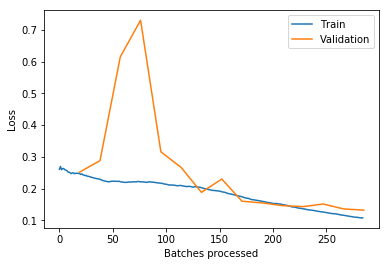

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.save('vgg19-5-imagenet-onefrth-stage-2')

In [28]:
learn.load('vgg19-5-imagenet-onefrth-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52),Image (3, 37, 52)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      

## Pass 1/3rd size

In [29]:
data = (src.transform(tfms, size=src_size//3)
        .databunch(bs=256).normalize(imagenet_stats))  

In [30]:
learn.data=data

In [31]:
learn.freeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


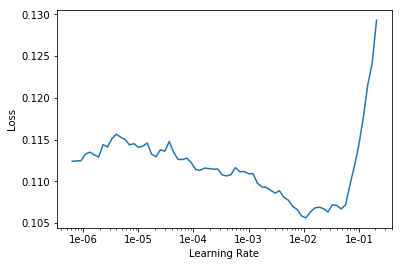

In [33]:
learn.recorder.plot()

In [34]:
lr=2e-3

In [35]:
learn.fit_one_cycle(15,max_lr=slice(lr)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.108148,0.130444,0.901619,0.944480,00:05
1,0.107460,0.129719,0.902305,0.947200,00:05
2,0.106369,0.129471,0.902952,0.947840,00:04
3,0.102898,0.128396,0.904286,0.948480,00:04
4,0.102008,0.129201,0.908762,0.947680,00:05
5,0.099786,0.126235,0.909219,0.949280,00:04
6,0.097409,0.127803,0.910553,0.948640,00:04
7,0.097411,0.125889,0.909924,0.949120,00:05
8,0.094400,0.126217,0.909619,0.950080,00:04
9,0.093461,0.127926,0.909314,0.950080,00:05


AttributeError: 'NoneType' object has no attribute 'mixup'

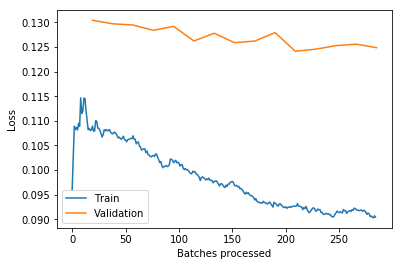

In [36]:
learn.recorder.plot_losses()

In [37]:
learn.save('vgg19-5-imagenet-onethrd-stage-3')

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


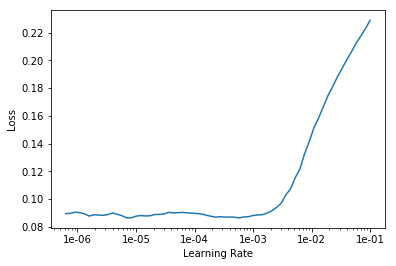

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr=1e-4
learn.fit_one_cycle(10,max_lr=slice(lr,2e-3),wd=1e-3).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.091041,0.123489,0.910381,0.951840,00:05
1,0.087014,0.122773,0.911333,0.951200,00:05
2,0.087929,0.139998,0.900114,0.947200,00:04
3,0.085038,0.126172,0.914210,0.951200,00:05
4,0.079686,0.134791,0.902952,0.954080,00:05
5,0.074569,0.120127,0.916286,0.956000,00:04
6,0.068948,0.118917,0.914686,0.956000,00:05
7,0.063373,0.117316,0.915905,0.954560,00:05
8,0.058810,0.118378,0.919010,0.957280,00:05
9,0.053978,0.119196,0.917505,0.956160,00:05


AttributeError: 'NoneType' object has no attribute 'mixup'

In [41]:
learn.save('vgg19-5-imagenet-onethrd-stage-4')

## Pass half size

In [42]:
data = (src.transform(tfms, size=src_size//2)
        .databunch(bs=128).normalize(imagenet_stats))

In [43]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


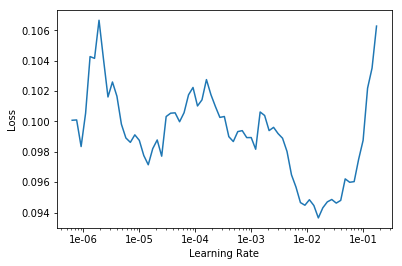

In [44]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [45]:
lr=2e-3
learn.fit_one_cycle(12,max_lr=slice(lr),wd=1e-4).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.087791,0.113616,0.917733,0.958880,00:05
1,0.088665,0.105571,0.922267,0.959840,00:05
2,0.085346,0.102428,0.925676,0.960960,00:05
3,0.081815,0.099661,0.928114,0.962080,00:05
4,0.081095,0.097507,0.930381,0.963360,00:05
5,0.076764,0.096945,0.931581,0.963520,00:05
6,0.075507,0.095171,0.933414,0.963040,00:05
7,0.072602,0.096338,0.933376,0.964640,00:05
8,0.071932,0.095760,0.933376,0.965600,00:05
9,0.072757,0.096646,0.932710,0.965920,00:05


AttributeError: 'NoneType' object has no attribute 'mixup'

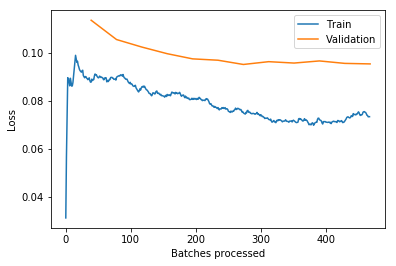

In [46]:
learn.recorder.plot_losses()

In [47]:
learn.save('vgg-5-imagenet-half-stage-5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


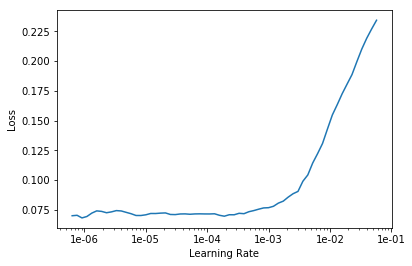

In [48]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [49]:
lr=2e-5
learn.fit_one_cycle(15,max_lr=slice(lr,2e-3)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.068482,0.094009,0.935219,0.964640,00:07
1,0.068666,0.097038,0.931676,0.964480,00:07
2,0.062877,0.105105,0.926210,0.964320,00:07
3,0.061221,0.102721,0.927333,0.964800,00:07
4,0.058228,0.105469,0.925752,0.956640,00:07
5,0.054467,0.111636,0.922248,0.963360,00:07
6,0.051795,0.119175,0.917372,0.961920,00:07


Traceback (most recent call last):
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda/envs/fastai_v1/lib/python3.6/multiprocessing/connection.py", line 404, in _send_by

KeyboardInterrupt: 

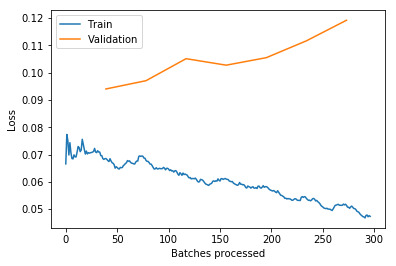

In [50]:
learn.recorder.plot_losses()

In [51]:
learn.save('resnet-5-imagenet-half-stage-6')

## Pass full size image

In [52]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))

In [53]:
learn.data=data

In [54]:
learn.data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


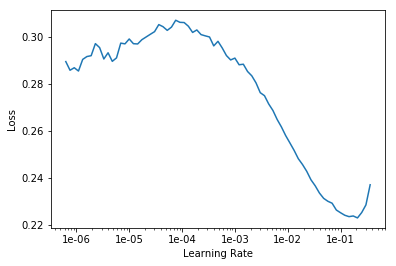

In [55]:
learn.load('resnet-5-imagenet-half-stage-6')
learn.freeze()
learn.data=data
learn.lr_find()
learn.recorder.plot()

In [56]:
lr=1e-2
learn.fit_one_cycle(15,slice(lr)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.269220,0.206176,0.846876,0.925120,00:18
1,0.214284,0.157349,0.884672,0.935040,00:17
2,0.176347,0.149106,0.889981,0.939360,00:17
3,0.144495,0.146533,0.893695,0.942880,00:17
4,0.124305,0.125313,0.907448,0.950240,00:17
5,0.111956,0.118943,0.912781,0.955360,00:16
6,0.099569,0.115110,0.919581,0.957600,00:17
7,0.089780,0.109723,0.924686,0.960320,00:17
8,0.085352,0.110241,0.923562,0.961120,00:16
9,0.080755,0.099733,0.926648,0.963200,00:17


AttributeError: 'NoneType' object has no attribute 'mixup'

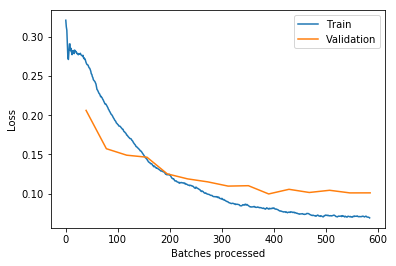

In [57]:
learn.recorder.plot_losses()

In [58]:
learn.save('vgg19-5-imagenet-full-stage-7')

In [59]:
learn.load('vgg19-5-imagenet-full-stage-7')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


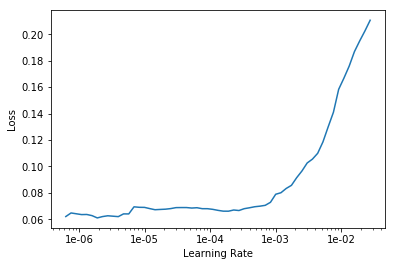

In [60]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [61]:
lr=2e-7
learn.fit_one_cycle(20,max_lr=slice(lr,1e-2)).mixup().to_f16()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.069180,0.100817,0.929010,0.964800,00:23
1,0.067325,0.101950,0.930343,0.964960,00:23
2,0.066957,0.105005,0.928838,0.963840,00:23
3,0.064223,0.116190,0.924267,0.962400,00:24
4,0.064041,0.116441,0.920476,0.961280,00:23
5,0.058779,0.118420,0.924038,0.964800,00:23
6,0.056865,0.112557,0.925886,0.962080,00:23
7,0.055251,0.122900,0.918171,0.962080,00:23
8,0.051582,0.106898,0.935681,0.968000,00:24
9,0.049810,0.093543,0.935771,0.968320,00:23


AttributeError: 'NoneType' object has no attribute 'mixup'

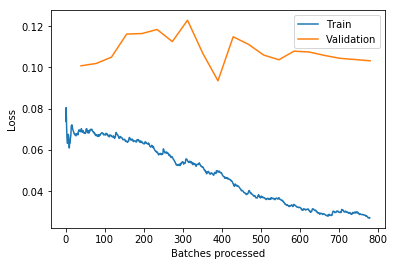

In [62]:
learn.recorder.plot_losses()

In [63]:
learn.save('vgg19-5-imagenet-full-stage-8')

In [64]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [56]:
test_pred_tta

(tensor([[9.9283e-01, 2.0347e-04, 9.6460e-04, 9.0035e-04, 5.3188e-04],
         [1.4024e-03, 1.9425e-04, 9.9864e-01, 3.3871e-04, 2.0669e-04],
         [5.7922e-01, 2.0019e-02, 5.9642e-04, 6.7006e-02, 2.8913e-01],
         ...,
         [9.3079e-02, 2.2776e-04, 8.4911e-01, 5.1968e-02, 1.7440e-03],
         [1.2892e-04, 9.9938e-01, 2.5478e-05, 1.7694e-04, 8.0086e-05],
         [9.8172e-01, 3.3297e-04, 1.0101e-04, 5.6791e-05, 1.7353e-02]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [65]:
preds = np.argmax(test_pred_tta[0], 1)
preds

tensor([0, 2, 0,  ..., 2, 1, 0])

In [66]:
a=array(preds)

In [ ]:
data.test_ds.x[1]

In [67]:
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]

In [68]:
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.head(10)

,image,category
0,2904735.jpg,1
1,2890616.jpg,3
2,2902677.jpg,1
3,2741468.jpg,4
4,2802610.jpg,5
5,1630950.jpg,4
6,2882184.jpg,3
7,2787793.jpg,2
8,2866032.jpg,1
9,2369442.jpg,2


In [75]:
len(submission)

2680

In [69]:
submission.to_csv(PATH/'submission_vgg19_multisz.csv',index=False)

## Merge the validation set

In [78]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [79]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))

In [82]:
data

ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [84]:
learn.load('resnet-5-imagenet-full-stage-8')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

In [85]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


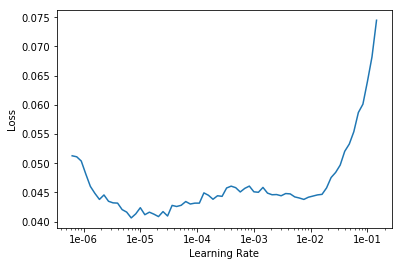

In [86]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [87]:
lr=9e-6
learn.fit_one_cycle(15,max_lr=slice(lr)).mixup().to_f16()

AttributeError: 'NoneType' object has no attribute 'mixup'

In [88]:
learn.save('resnet-5-imagenet-full-stage-8-noval')

In [89]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [90]:
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnet18_multisz-noval.csv',index=False)